In [235]:
import pandas as pd
import time
import datetime
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm import tqdm
from glob import glob
from datetime import timedelta

### Basic Data

In [33]:
my_api_key = ''

In [8]:
df = pd.read_csv('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/lol_api/high_tier_user_1009.csv')

In [49]:
df['puuid'][df['summonerName']=='Hide on bush']

4160    WtTsQKePbPTEtwvNVXSm97PwF5rmYj5T2qsHXRm8vlmR8h...
Name: puuid, dtype: object

### Get match_id

In [28]:
dates_range = pd.date_range(start='2021/06/16', end='2021/10/10',freq='1D')

In [54]:
date_start_list = []
date_end_list = []
for dd in dates_range:
    date_start_list.append(int(time.mktime(datetime.datetime(
        dd.year, dd.month, dd.day, 0, 0, 0).timetuple()
    )))
    
    date_end_list.append(int(time.mktime(datetime.datetime(
        dd.year, dd.month, dd.day, 23, 59, 59).timetuple()
    )))

In [55]:
match_id_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?startTime={}&endTime={}&type=ranked&start=0&count=100&api_key={}'

In [57]:
urls_list = []
for start_d, end_d in zip(date_start_list,date_end_list):
    urls_list.append(
        match_id_url.format(df['puuid'][4160],start_d,end_d,my_api_key))

In [68]:
i = 0
match_ids = []
for urll in tqdm(urls_list):
    if i == 99:
        time.sleep(120)        
        i = 0
    else:
        i += 1
        
    reqq = eval(requests.get(urll).text)
    match_ids += reqq

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [02:32<00:00,  1.30s/it]


### Get match data

In [69]:
match_hist_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'

In [86]:
match_hist_header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
}

In [89]:
match_hist = []
i = 0
for match_id in tqdm(match_ids):
    if i == 99:
        time.sleep(120)        
        i = 0
    else:
        i += 1
        
    reqq = requests.get(match_hist_url.format(match_id,my_api_key),headers=match_hist_header).text
    
    with open('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/data_{}.json'.format(match_id),
              'w') as f:
        json.dump(reqq, f)

100%|████████████████████████████████████████████████████████████████████████████████| 527/527 [13:00<00:00,  1.48s/it]


### Preprocessing 

#### Sample Preprocessing

In [93]:
sample_json = json.loads(reqq)

In [99]:
[x for x in sample_json.keys()]

['metadata', 'info']

In [100]:
sample_json['metadata']

{'dataVersion': '2',
 'matchId': 'KR_5476190678',
 'participants': ['miX-Ec18NSvbEfg7ZVC5U2gMGUnWrFWNtPF1rrVShw8sUBjphcQ95z16kSySlYl3Z-UX4uBQt9whmw',
  'wurdMhgmPY4h0njsbBrtpona7Ev9ZwA7Mq16OHijwCAyFYC64n2XJATTVXCCvtifObhFvlAOZyIqtw',
  'yJCHxAO50M_nKpX6REdXf037ETg4slC6G_Ln2XcmQzZvbPVRjuVZQthUvjUyUqQVbDFBn_Yh41aF6A',
  'MxfGQjIMNAhKFebnMwvz0-9KkTSpotOhSY81JquAfq_qEL13WgRZnA2LouWYTCTWEo7_MUjnbC86Rw',
  'ZPevuzNMbmrNuCgok1NWgIAdiy0LUy8DzvNw4dPZJtqHsRQP8ztY06B-r74ewrRoXZx-JdMCl4Ur0w',
  'Q0ucTiDnPFhILDTOjUttDj7Mr6EfCoGOEOUPQY8X-TsVNKYqZide__fLb1c3uQ2KMsKqK-OHB7W2Lw',
  'WtTsQKePbPTEtwvNVXSm97PwF5rmYj5T2qsHXRm8vlmR8hPBA5E3hf4hDC8S_5UHEMZkZOS9CfWEKQ',
  '6KNPMsWYUl43fbMegw4stpZwuqrWUUoQIRX1-1f9XVbIcDdQ_znlBPxf1PkSmT1wKaLwBc54ygUrCw',
  'X1oqF2m_5yBhA885PxuwIjX5b2-O60TZOTJvjPH0Hga6vxH_NkSrr1MnCugwHpWTFpUpsSoi0ajsfg',
  '2nOdCLN3-YEfC12GuVKIPBeDKtQuownkfCSDcx5HpH9283WE8Yj5W-qbte7oFuYyNjhgmCxR26WQzA']}

In [105]:
[x for x in sample_json['info'].keys()]

['gameCreation',
 'gameDuration',
 'gameId',
 'gameMode',
 'gameName',
 'gameStartTimestamp',
 'gameType',
 'gameVersion',
 'mapId',
 'participants',
 'platformId',
 'queueId',
 'teams',
 'tournamentCode']

In [110]:
for info_col in ['gameCreation','gameDuration','gameId','gameMode','gameName','gameStartTimestamp',
                 'gameType','gameVersion','mapId','platformId','queueId','tournamentCode']:
    print(info_col,':',sample_json['info'][info_col])

gameCreation : 1632582258000
gameDuration : 1694571
gameId : 5476190678
gameMode : CLASSIC
gameName : teambuilder-match-5476190678
gameStartTimestamp : 1632582277499
gameType : MATCHED_GAME
gameVersion : 11.19.398.9466
mapId : 11
platformId : KR
queueId : 420
tournamentCode : 


In [118]:
part_user = sample_json['info']['participants'][0]
part_user['perks']

{'statPerks': {'defense': 5002, 'flex': 5008, 'offense': 5005},
 'styles': [{'description': 'primaryStyle',
   'selections': [{'perk': 8214, 'var1': 411, 'var2': 1085, 'var3': 0},
    {'perk': 8226, 'var1': 250, 'var2': 545, 'var3': 0},
    {'perk': 8210, 'var1': 1, 'var2': 0, 'var3': 0},
    {'perk': 8237, 'var1': 257, 'var2': 0, 'var3': 0}],
   'style': 8200},
  {'description': 'subStyle',
   'selections': [{'perk': 8345, 'var1': 3, 'var2': 0, 'var3': 0},
    {'perk': 8352, 'var1': 143, 'var2': 1003, 'var3': 637}],
   'style': 8300}]}

In [143]:
sample_json['info']['participants']

[{'assists': 6,
  'baronKills': 0,
  'bountyLevel': 0,
  'champExperience': 10207,
  'champLevel': 13,
  'championId': 26,
  'championName': 'Zilean',
  'championTransform': 0,
  'consumablesPurchased': 3,
  'damageDealtToBuildings': 2768,
  'damageDealtToObjectives': 3039,
  'damageDealtToTurrets': 2768,
  'damageSelfMitigated': 3792,
  'deaths': 3,
  'detectorWardsPlaced': 3,
  'doubleKills': 0,
  'dragonKills': 0,
  'firstBloodAssist': False,
  'firstBloodKill': False,
  'firstTowerAssist': False,
  'firstTowerKill': False,
  'gameEndedInEarlySurrender': False,
  'gameEndedInSurrender': False,
  'goldEarned': 8045,
  'goldSpent': 7775,
  'individualPosition': 'TOP',
  'inhibitorKills': 0,
  'inhibitorTakedowns': 0,
  'inhibitorsLost': 1,
  'item0': 2033,
  'item1': 3158,
  'item2': 3165,
  'item3': 1028,
  'item4': 6656,
  'item5': 0,
  'item6': 3340,
  'itemsPurchased': 17,
  'killingSprees': 0,
  'kills': 0,
  'lane': 'TOP',
  'largestCriticalStrike': 0,
  'largestKillingSpree': 0

In [119]:
part_user['perks'].keys()

dict_keys(['statPerks', 'styles'])

In [132]:
del part_user['perks']

In [146]:
part_user

{'assists': 6,
 'baronKills': 0,
 'bountyLevel': 0,
 'champExperience': 10207,
 'champLevel': 13,
 'championId': 26,
 'championName': 'Zilean',
 'championTransform': 0,
 'consumablesPurchased': 3,
 'damageDealtToBuildings': 2768,
 'damageDealtToObjectives': 3039,
 'damageDealtToTurrets': 2768,
 'damageSelfMitigated': 3792,
 'deaths': 3,
 'detectorWardsPlaced': 3,
 'doubleKills': 0,
 'dragonKills': 0,
 'firstBloodAssist': False,
 'firstBloodKill': False,
 'firstTowerAssist': False,
 'firstTowerKill': False,
 'gameEndedInEarlySurrender': False,
 'gameEndedInSurrender': False,
 'goldEarned': 8045,
 'goldSpent': 7775,
 'individualPosition': 'TOP',
 'inhibitorKills': 0,
 'inhibitorTakedowns': 0,
 'inhibitorsLost': 1,
 'item0': 2033,
 'item1': 3158,
 'item2': 3165,
 'item3': 1028,
 'item4': 6656,
 'item5': 0,
 'item6': 3340,
 'itemsPurchased': 17,
 'killingSprees': 0,
 'kills': 0,
 'lane': 'TOP',
 'largestCriticalStrike': 0,
 'largestKillingSpree': 0,
 'largestMultiKill': 0,
 'longestTimeSpe

#### Preprocessing function

In [175]:
def riot_json_preprocessing(json_data):
    matchid = json_data['metadata']['matchId']
    
    return_dfs = []
    for json_user in json_data['info']['participants']:
        return_dict = {}
        perks = str(json_user['perks'])
        del json_user['perks']
    
        json_user['matchId'] = matchid
        json_user['perks'] = perks
        return_dfs.append(pd.DataFrame(json_user,index=[0]))
    
    return pd.concat(return_dfs).reset_index(drop=True)

In [179]:
tmp_df = riot_json_preprocessing(json.loads(reqq))
tmp_df.head(3)

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,...,turretTakedowns,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,matchId,perks
0,6,0,0,10207,13,26,Zilean,0,3,2768,...,3,6,0,31,3,5,12,False,KR_5476190678,"{'statPerks': {'defense': 5002, 'flex': 5008, ..."
1,4,0,0,11969,14,76,Nidalee,0,6,1492,...,2,6,0,45,6,10,6,False,KR_5476190678,"{'statPerks': {'defense': 5002, 'flex': 5008, ..."
2,6,0,0,12804,14,777,Yone,0,2,1503,...,1,6,0,17,1,2,7,False,KR_5476190678,"{'statPerks': {'defense': 5003, 'flex': 5008, ..."


#### Make bind data

In [196]:
data_path = glob('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/*.json')
raw_json = []
for path in data_path:
    with open(path,'r') as f:
        raw_json.append(json.load(f))

In [209]:
faker_df = pd.Series(raw_json).apply(lambda x : riot_json_preprocessing(json.loads(x)))
faker_df = pd.concat(list(faker_df))
faker_df = faker_df.reset_index(drop=True)
faker_df.head(5)

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,matchId,perks,inhibitorTakedowns,nexusTakedowns,turretTakedowns
0,6,0,0,14987,16,887,Gwen,0,3,5715,...,15,2,1,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
1,10,1,0,12992,14,78,Poppy,0,6,2646,...,32,6,5,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
2,7,0,2,16214,16,236,Lucian,0,8,9738,...,49,7,13,16,True,KR_5265344658,"{'statPerks': {'defense': 5003, 'flex': 5008, ...",NaN,NaN,NaN
3,9,0,7,14664,15,110,Varus,0,4,5347,...,23,1,6,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
4,19,0,0,9690,12,412,Thresh,0,12,587,...,61,10,7,34,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5003, ...",NaN,NaN,NaN


In [218]:
faker_df.to_csv('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/faker_df.csv',
                index=False,encoding='utf-8-sig')

### eda

#### 가장 많이 만난 유저?

In [284]:
faker_df.groupby('summonerName',as_index=False).size().sort_values('size',ascending=False)[0:20]

,summonerName,size
302,Hide on bush,527
527,T1 Canna,21
1144,고등학생,21
114,BJ갈배,21
414,Mocha,16
366,La Casa de PapeI,15
165,Cuzzzzzzz,14
1789,현주입니다,14
1325,무인데용,13
1669,짜요짜요먹고싶어,12


#### 어떤 챔피언을 많이 썼을까?

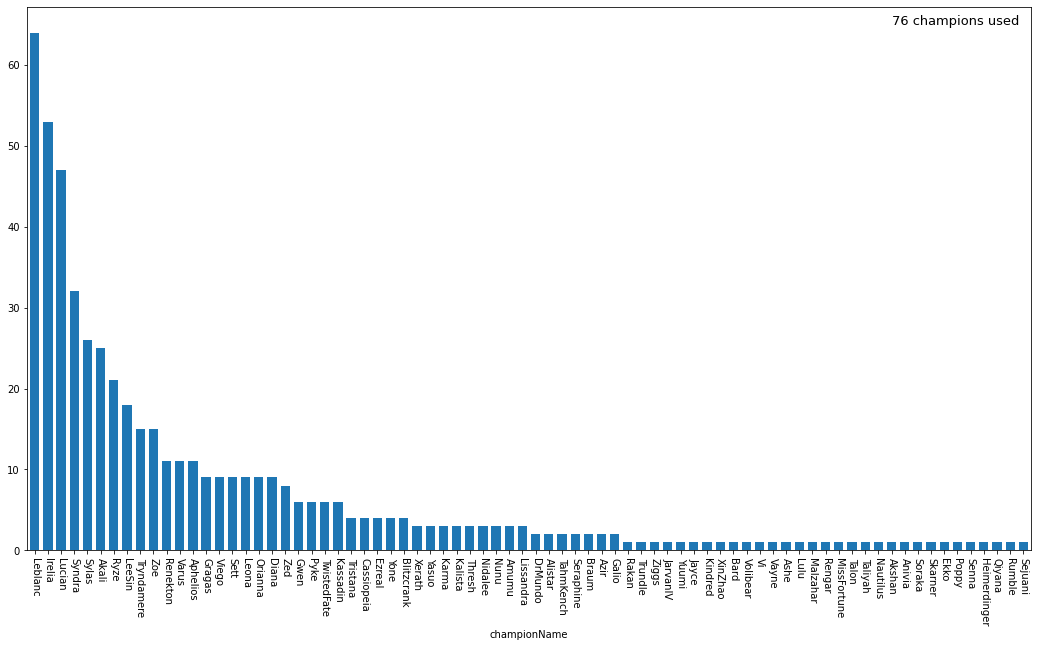

In [321]:
champions_count = faker_df[faker_df['summonerName']=='Hide on bush'].groupby(
    'championName',as_index=True).size().sort_values(ascending=False)

champions_count.plot.bar(figsize=(18,10),width=0.7)
plt.text(65,65,'{} champions used'.format(len(champions_count)),size=13)
plt.xticks(rotation=-90);

#### 퍼블 & 어시스트?

In [374]:
first_blood_win = faker_df[
    ['matchId','teamId','firstBloodKill','win']].drop_duplicates()
first_blood_win.head(3)

,matchId,teamId,firstBloodKill,win
0,KR_5265344658,100,False,True
5,KR_5265344658,200,False,False
6,KR_5265344658,200,True,False


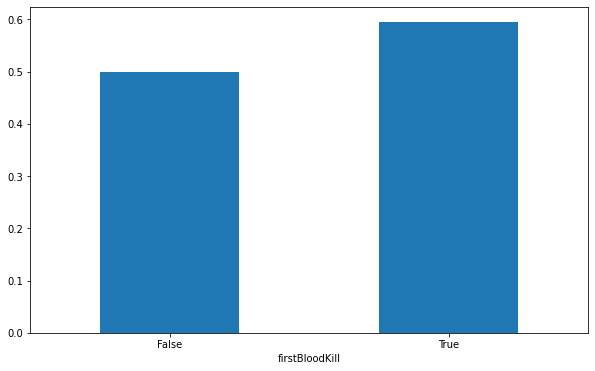

In [392]:
plt.figure(figsize=(10,6))
first_blood_win.groupby('firstBloodKill')['win'].mean().plot.bar()
plt.xticks(rotation=0);

In [404]:
first_assist_win = faker_df[['matchId','teamId','firstBloodKill','firstBloodAssist','win']]

first_assist_win.head(3)

,matchId,teamId,firstBloodKill,firstBloodAssist,win
0,KR_5265344658,100,False,False,True
1,KR_5265344658,100,False,False,True
2,KR_5265344658,100,False,False,True


In [ ]:
first_assist_win.groupby('matchId')

In [290]:
[x for x in faker_df.columns]

['assists',
 'baronKills',
 'bountyLevel',
 'champExperience',
 'champLevel',
 'championId',
 'championName',
 'championTransform',
 'consumablesPurchased',
 'damageDealtToBuildings',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'deaths',
 'detectorWardsPlaced',
 'doubleKills',
 'dragonKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstTowerAssist',
 'firstTowerKill',
 'gameEndedInEarlySurrender',
 'gameEndedInSurrender',
 'goldEarned',
 'goldSpent',
 'individualPosition',
 'inhibitorKills',
 'inhibitorsLost',
 'item0',
 'item1',
 'item2',
 'item3',
 'item4',
 'item5',
 'item6',
 'itemsPurchased',
 'killingSprees',
 'kills',
 'lane',
 'largestCriticalStrike',
 'largestKillingSpree',
 'largestMultiKill',
 'longestTimeSpentLiving',
 'magicDamageDealt',
 'magicDamageDealtToChampions',
 'magicDamageTaken',
 'neutralMinionsKilled',
 'nexusKills',
 'nexusLost',
 'objectivesStolen',
 'objectivesStolenAssists',
 'participantId',
 'pentaKills',
 'physicalDam